<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Buddhika/Research_IT22564122_Hybrid_Model(MobileNetV2%2C_DenseNet121).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from zipfile import ZipFile
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

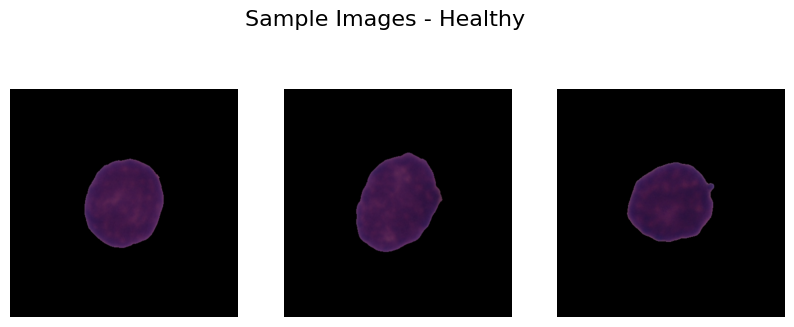

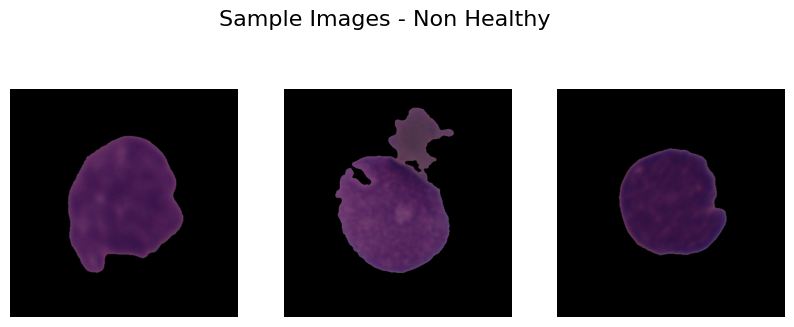

In [3]:
path = '/content/drive/MyDrive/New folder'
classes = ['Healthy', 'Non Healthy']

# ==========================================
# 3. VISUALIZE SAMPLE IMAGES
# ==========================================
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'Sample Images - {cat}', fontsize=16)

    for i in range(3):
        img = np.array(Image.open(os.path.join(image_dir, images[np.random.randint(len(images))])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [4]:
# ==========================================
# 4. PARAMETERS
# ==========================================
IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 20
SPLIT = 0.2

# ==========================================
# 5. LOAD & PREPROCESS DATA
# ==========================================
X, Y = [], []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.bmp')

    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # IMPORTANT
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        Y.append(i)

X = np.array(X, dtype="float32")
Y = np.array(Y)

Y_cat = keras.utils.to_categorical(Y, num_classes=len(classes))

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_cat, test_size=SPLIT, random_state=42, stratify=Y
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")

Train: (837, 256, 256, 3), Validation: (210, 256, 256, 3)


In [5]:
# ==========================================
# 6. CLASS WEIGHTS (OPTIONAL BUT RECOMMENDED)
# ==========================================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y),
    y=Y
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.9914772727272727), 1: np.float64(1.0086705202312138)}


In [6]:
# ==========================================
# 7. DATA AUGMENTATION
# ==========================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
], name="augmentation")

In [14]:
# ==========================================
# 8. HYBRID MODEL ARCHITECTURE
# ==========================================
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(input_layer)

# Preprocessing for each backbone
mobile_input = mobilenet_preprocess(x)
dense_input = densenet_preprocess(x)

# MobileNetV2 Branch
base_mobile = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=mobile_input
)
base_mobile.trainable = False
mobile_features = layers.GlobalAveragePooling2D()(base_mobile.output)

# DenseNet121 Branch
base_dense = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=dense_input
)
base_dense.trainable = False
dense_features = layers.GlobalAveragePooling2D()(base_dense.output)

# Feature Fusion
combined = layers.Concatenate()([mobile_features, dense_features])

# Classification Head
x = layers.Dense(512, activation='relu')(combined)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(len(classes), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()

/tmp/ipython-input-2885100317.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobile = MobileNetV2(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_4       │ (None, 256, 256,  │          0 │ augmentation[1][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ true_divide_4[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_5       │ (None, 256, 256,  │          0 │ add_1[0][0]       │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 262, 262,  │          0 │ true_divide_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r

 Total params: 10,610,562 (40.48 MB)

 Trainable params: 1,313,538 (5.01 MB)

 Non-trainable params: 9,297,024 (35.47 MB)

In [15]:
# ==========================================
# 9. COMPILE (PHASE 1)
# ==========================================
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [16]:
# ==========================================
# 10. TRAINING – PHASE 1 (FEATURE EXTRACTION)
# ==========================================
history_1 = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5579 - loss: 1.1227 - val_accuracy: 0.4952 - val_loss: 0.8680
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.6906 - loss: 0.7889 - val_accuracy: 0.4952 - val_loss: 0.8774
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - accuracy: 0.6838 - loss: 0.7242 - val_accuracy: 0.5048 - val_loss: 0.8005
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 534ms/step - accuracy: 0.6723 - loss: 0.7443 - val_accuracy: 0.5381 - val_loss: 0.7340
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.7098 - loss: 0.7462 - val_accuracy: 0.5476 - val_loss: 0.7750
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 545ms/step - accuracy: 0.7250 - loss: 0.6998 - val_accuracy: 0.5571 - val_loss: 0.7953
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.7210 - loss: 0.7271 - val_accuracy: 0.5524 - val_loss: 0.8119
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.7349 - loss: 0.6645 - val_accuracy: 0.5

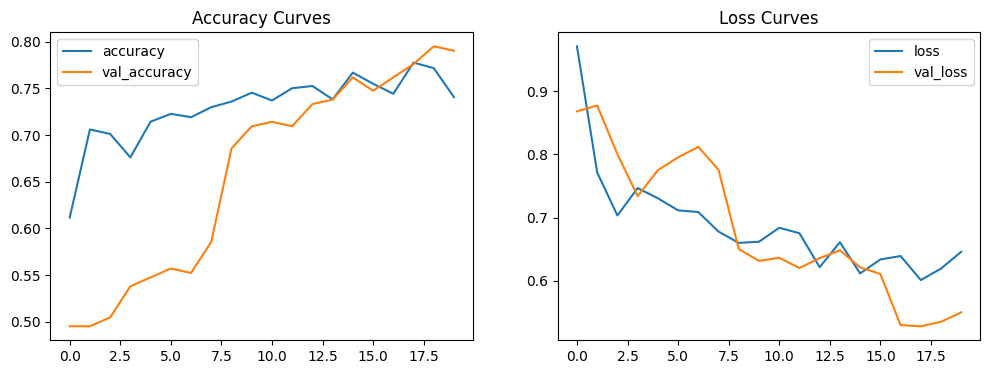

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 914ms/step


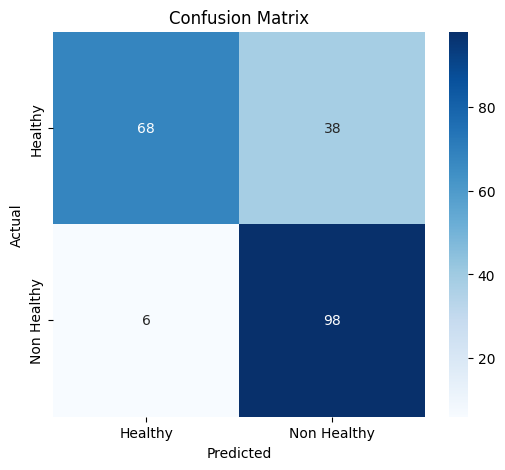

In [17]:
# Plot Accuracy and Loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
history_df = pd.DataFrame(history_1.history)

history_df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
ax[0].set_title('Accuracy Curves')

history_df[['loss', 'val_loss']].plot(ax=ax[1])
ax[1].set_title('Loss Curves')
plt.show()

# Confusion Matrix
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# ==========================================
# 11. FINE-TUNING (PHASE 2)
# ==========================================
for layer in base_mobile.layers[-30:]:
    layer.trainable = True

for layer in base_dense.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_2 = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6823 - loss: 0.7337 - val_accuracy: 0.8000 - val_loss: 0.5266
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 590ms/step - accuracy: 0.7104 - loss: 0.7335 - val_accuracy: 0.7857 - val_loss: 0.5354
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 590ms/step - accuracy: 0.7403 - loss: 0.6879 - val_accuracy: 0.7857 - val_loss: 0.5483
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 595ms/step - accuracy: 0.7227 - loss: 0.6860 - val_accuracy: 0.7905 - val_loss: 0.5625
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 608ms/step - accuracy: 0.6896 - loss: 0.7134 - val_accuracy: 0.7857 - val_loss: 0.5700
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 592ms/step - accuracy: 0.7374 - loss: 0.7013 - val_accuracy: 0.7810 - val_loss: 0.5806
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 595ms/step - accuracy: 0.7178 - loss: 0.6940 - val_accuracy: 0.7762 - val_loss: 0.5869
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 593ms/step - accuracy: 0.7217 - loss: 0.7539 - val_accuracy: 0.78

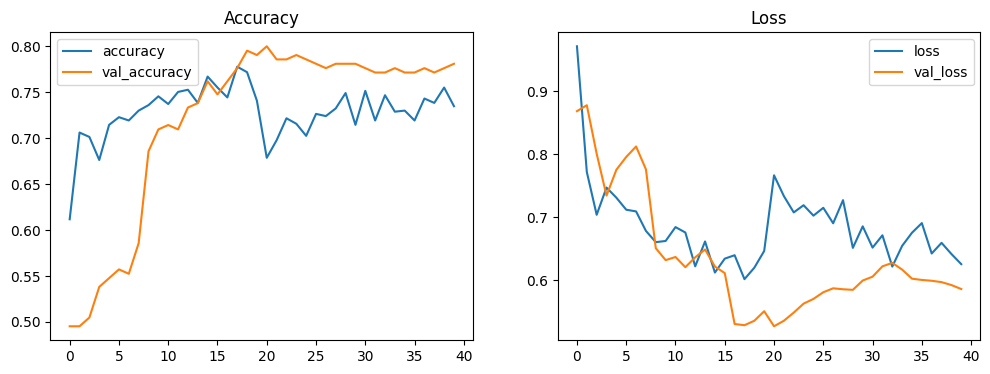

In [19]:
# ==========================================
# 12. TRAINING CURVES
# ==========================================
history = pd.concat([
    pd.DataFrame(history_1.history),
    pd.DataFrame(history_2.history)
], ignore_index=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
history[['accuracy', 'val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy")

history[['loss', 'val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
              precision    recall  f1-score   support

     Healthy       0.87      0.67      0.76       106
 Non Healthy       0.73      0.89      0.80       104

    accuracy                           0.78       210
   macro avg       0.80      0.78      0.78       210
weighted avg       0.80      0.78      0.78       210



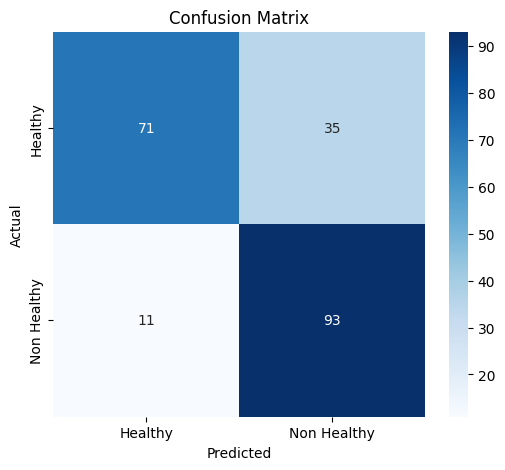

In [20]:
# ==========================================
# 13. EVALUATION
# ==========================================
Y_pred = model.predict(X_val)
Y_pred_cls = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

print(classification_report(Y_true, Y_pred_cls, target_names=classes))

cm = confusion_matrix(Y_true, Y_pred_cls)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
model_path="/content/drive/MyDrive/New folder/Hybrid_Model(MobileNetV2,_DenseNet121).keras"
model.save(model_path)